# Molten Salt Comparison

In this tutorial we will compare two large molten salt simulation of NaCl and KCl to see how their structures and properties differ from one another.

This tutorial assumes that you are already familiar with the general MDSuite interface and have looked over the previous tutorial.

In [1]:
import mdsuite as mds
import matplotlib.pyplot as plt
from zinchub import DataHub
import tensorflow as tf
import numpy as np
from scipy.integrate import cumtrapz

2022-06-27 17:15:03.451033: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/targets/x86_64-linux/lib:/usr/local/cuda-11.2/targets/x86_64-linux/lib:
2022-06-27 17:15:03.451061: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In this tutorial we are using two, 1000 atom simulations of NaCl and KCl run for 5000 time steps. Keep in mind, due to the size of these files (~140 MB each) they may take some time to download and unzip (within a minute depending on internet connection).

In [2]:
NaCl_file = DataHub(url="https://github.com/zincware/DataHub/tree/main/NaCl_rnd_md", tag="v0.1.0")
KCl_file = DataHub(url="https://github.com/zincware/DataHub/tree/main/KCl_rnd_md", tag="v0.1.0")

KCl_data = KCl_file.get_file('.')[0]
NaCl_data = NaCl_file.get_file('.')[0]

In [3]:
md_project = mds.Project(name="Molten_Salt_Comparison", storage_path='.')

2022-06-27 17:15:21,601 - INFO: Creating new project Molten_Salt_Comparison


Again, depending on your computer, adding the data may take up between 25s to 1m total.

In [4]:
NaCl_experiment = md_project.add_experiment(
    name="NaCl", timestep=0.002, units='metal', temperature=1200.0, simulation_data=NaCl_data
)
KCl_experiment = md_project.add_experiment(
    name="KCl", timestep=0.002, units='metal', temperature=1200.0, simulation_data=KCl_data
)

2022-06-27 17:15:21,828 - INFO: Creating a new experiment!


0it [00:00, ?it/s]


2022-06-27 17:15:32,150 - INFO: Creating a new experiment!


0it [00:00, ?it/s]


## Structural Information

The first thing we want to study is how the structure of these salts compare. Let's do so by comparing the RDFs, ADFs, coordination numbers, and potential of mean force values for the dominant interactions in each system.

For each of these computations we will directly call the project. This is simply a faster way of performing the same computation on all of the experiments at one time. What is returns is a dictionary of information for each experiment. We will demonstrate here how one can use this to extract relevant information.

In [5]:
RDF_Data = md_project.run.RadialDistributionFunction(number_of_configurations=500, cutoff=15.0)

100%|███████████████████████████████| 500/500 [00:24<00:00, 20.83it/s]


Loading BokehJS ...

100%|███████████████████████████████| 500/500 [00:22<00:00, 22.05it/s]


Loading BokehJS ...

In [6]:
NaCl_experiment.run.CoordinationNumbers(
    rdf_data=RDF_Data['NaCl'], savgol_window_length=110, savgol_order=9, number_of_shells=3
)

Loading BokehJS ...

Exp1_Coordination_Numbers_3

In [7]:
KCl_experiment.run.CoordinationNumbers(
    rdf_data=RDF_Data['KCl'], savgol_window_length=110, savgol_order=7, number_of_shells=2
)

Loading BokehJS ...

Exp2_Coordination_Numbers_4

In [8]:
KCl_experiment.run.PotentialOfMeanForce(
    rdf_data=RDF_Data['KCl'], savgol_window_length=110, savgol_order=7, number_of_shells=2
)

Loading BokehJS ...

Exp2_Potential_of_Mean_Force_5

In [9]:
radii = RDF_Data['NaCl']['Na_Cl']['x']
NaCl_rdf = RDF_Data['NaCl']['Na_Cl']['y']
KCl_rdf = RDF_Data['KCl']['Cl_K']['y']

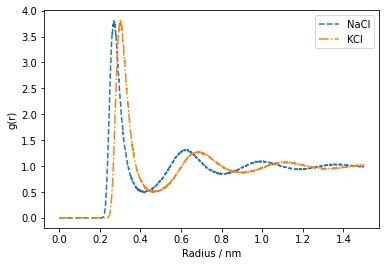

In [10]:
plt.plot(radii, NaCl_rdf, '--', label='NaCl')
plt.plot(radii, KCl_rdf, '-.', label='KCl')
plt.legend()
plt.xlabel("Radius / nm")
plt.ylabel("g(r)")
plt.show()

We can see that the peak heights of the two salts are very similar whilst the position of the NaCl is left-shifted with respect to the KCl. This suggests that the Na and Cl ions are closer together than the K and Cl ions in their respective systems. This is consistent with the fact that Potassium atoms are larger than Sodium atoms and therefore would equilibrate at a greater separation. Now let's further investigate the peak height by looking at coordination numbers.

In [11]:
data = md_project.run.GreenKuboDiffusionCoefficients(data_range=499, correlation_time=10)

Cl: 100%|███████████████████████████████| 1/1 [00:14<00:00, 14.05s/it]


Loading BokehJS ...

Cl: 100%|███████████████████████████████| 1/1 [00:14<00:00, 14.09s/it]


Loading BokehJS ...

In [12]:
data["NaCl"].data_dict["Na"]["diffusion_coefficient"]

[1.1699497443817538e-08]

In [13]:
data["NaCl"].data_dict["Cl"]["diffusion_coefficient"]

[9.289197074221025e-09]

In [14]:
md_project.experiments.NaCl.species["Na"].charge = 1
md_project.experiments.NaCl.species["Cl"].charge = -1
md_project.experiments.KCl.species["K"].charge = 1
md_project.experiments.KCl.species["Cl"].charge = -1

In [15]:
md_project.run.GreenKuboIonicConductivity(data_range=402)

Applying transformation 'Ionic_Current': 100%|█| 1/1 [00:00<00:00,  7.
100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.62s/it]


Loading BokehJS ...

Applying transformation 'Ionic_Current': 100%|█| 1/1 [00:00<00:00,  5.
100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


Loading BokehJS ...

{'NaCl': Exp1_Green_Kubo_Ionic_Conductivity_8,
 'KCl': Exp2_Green_Kubo_Ionic_Conductivity_9}